In [1]:
import matplotlib.pyplot as plt
import numpy as np

from read_1t1r_data import read_1t1r_data

from matplotlib import rcParams
rcParams.update({'figure.figsize': (12,6)})


read_1t1r_data recursively searches the folder for excel files starting with 'Prog' and reads them

these files contain data collected during multiple(2000) set/reset operations across multiple(20) 1T1R devices

the most important components of this data are Low Resistance State (LRS) values paired with the current and the voltage at the gate during the set operation

In [2]:
_, prog_data, filenames = read_1t1r_data(dir='.', type='Prog')

print(f"{len(prog_data)} devices tested using the analog programming test method Prog")

20 devices tested using the analog programming test method Prog


each device contains data with the following keys, these can also be thought of as column labels where each row is recored after a cycle of operations (set/reset/read):

In [3]:
print(f'column labels: {prog_data[0].keys()}')

column labels: dict_keys([1, 'LRS', 'HRS', 'setv', 'resetv', 'gatev', 'vread', 'LRSreadi', 'HRSreadi', 'seti', 'reseti'])


lets plot LRS vs. gate voltage in log scale for all devices to make sure there aren't any faulty devices

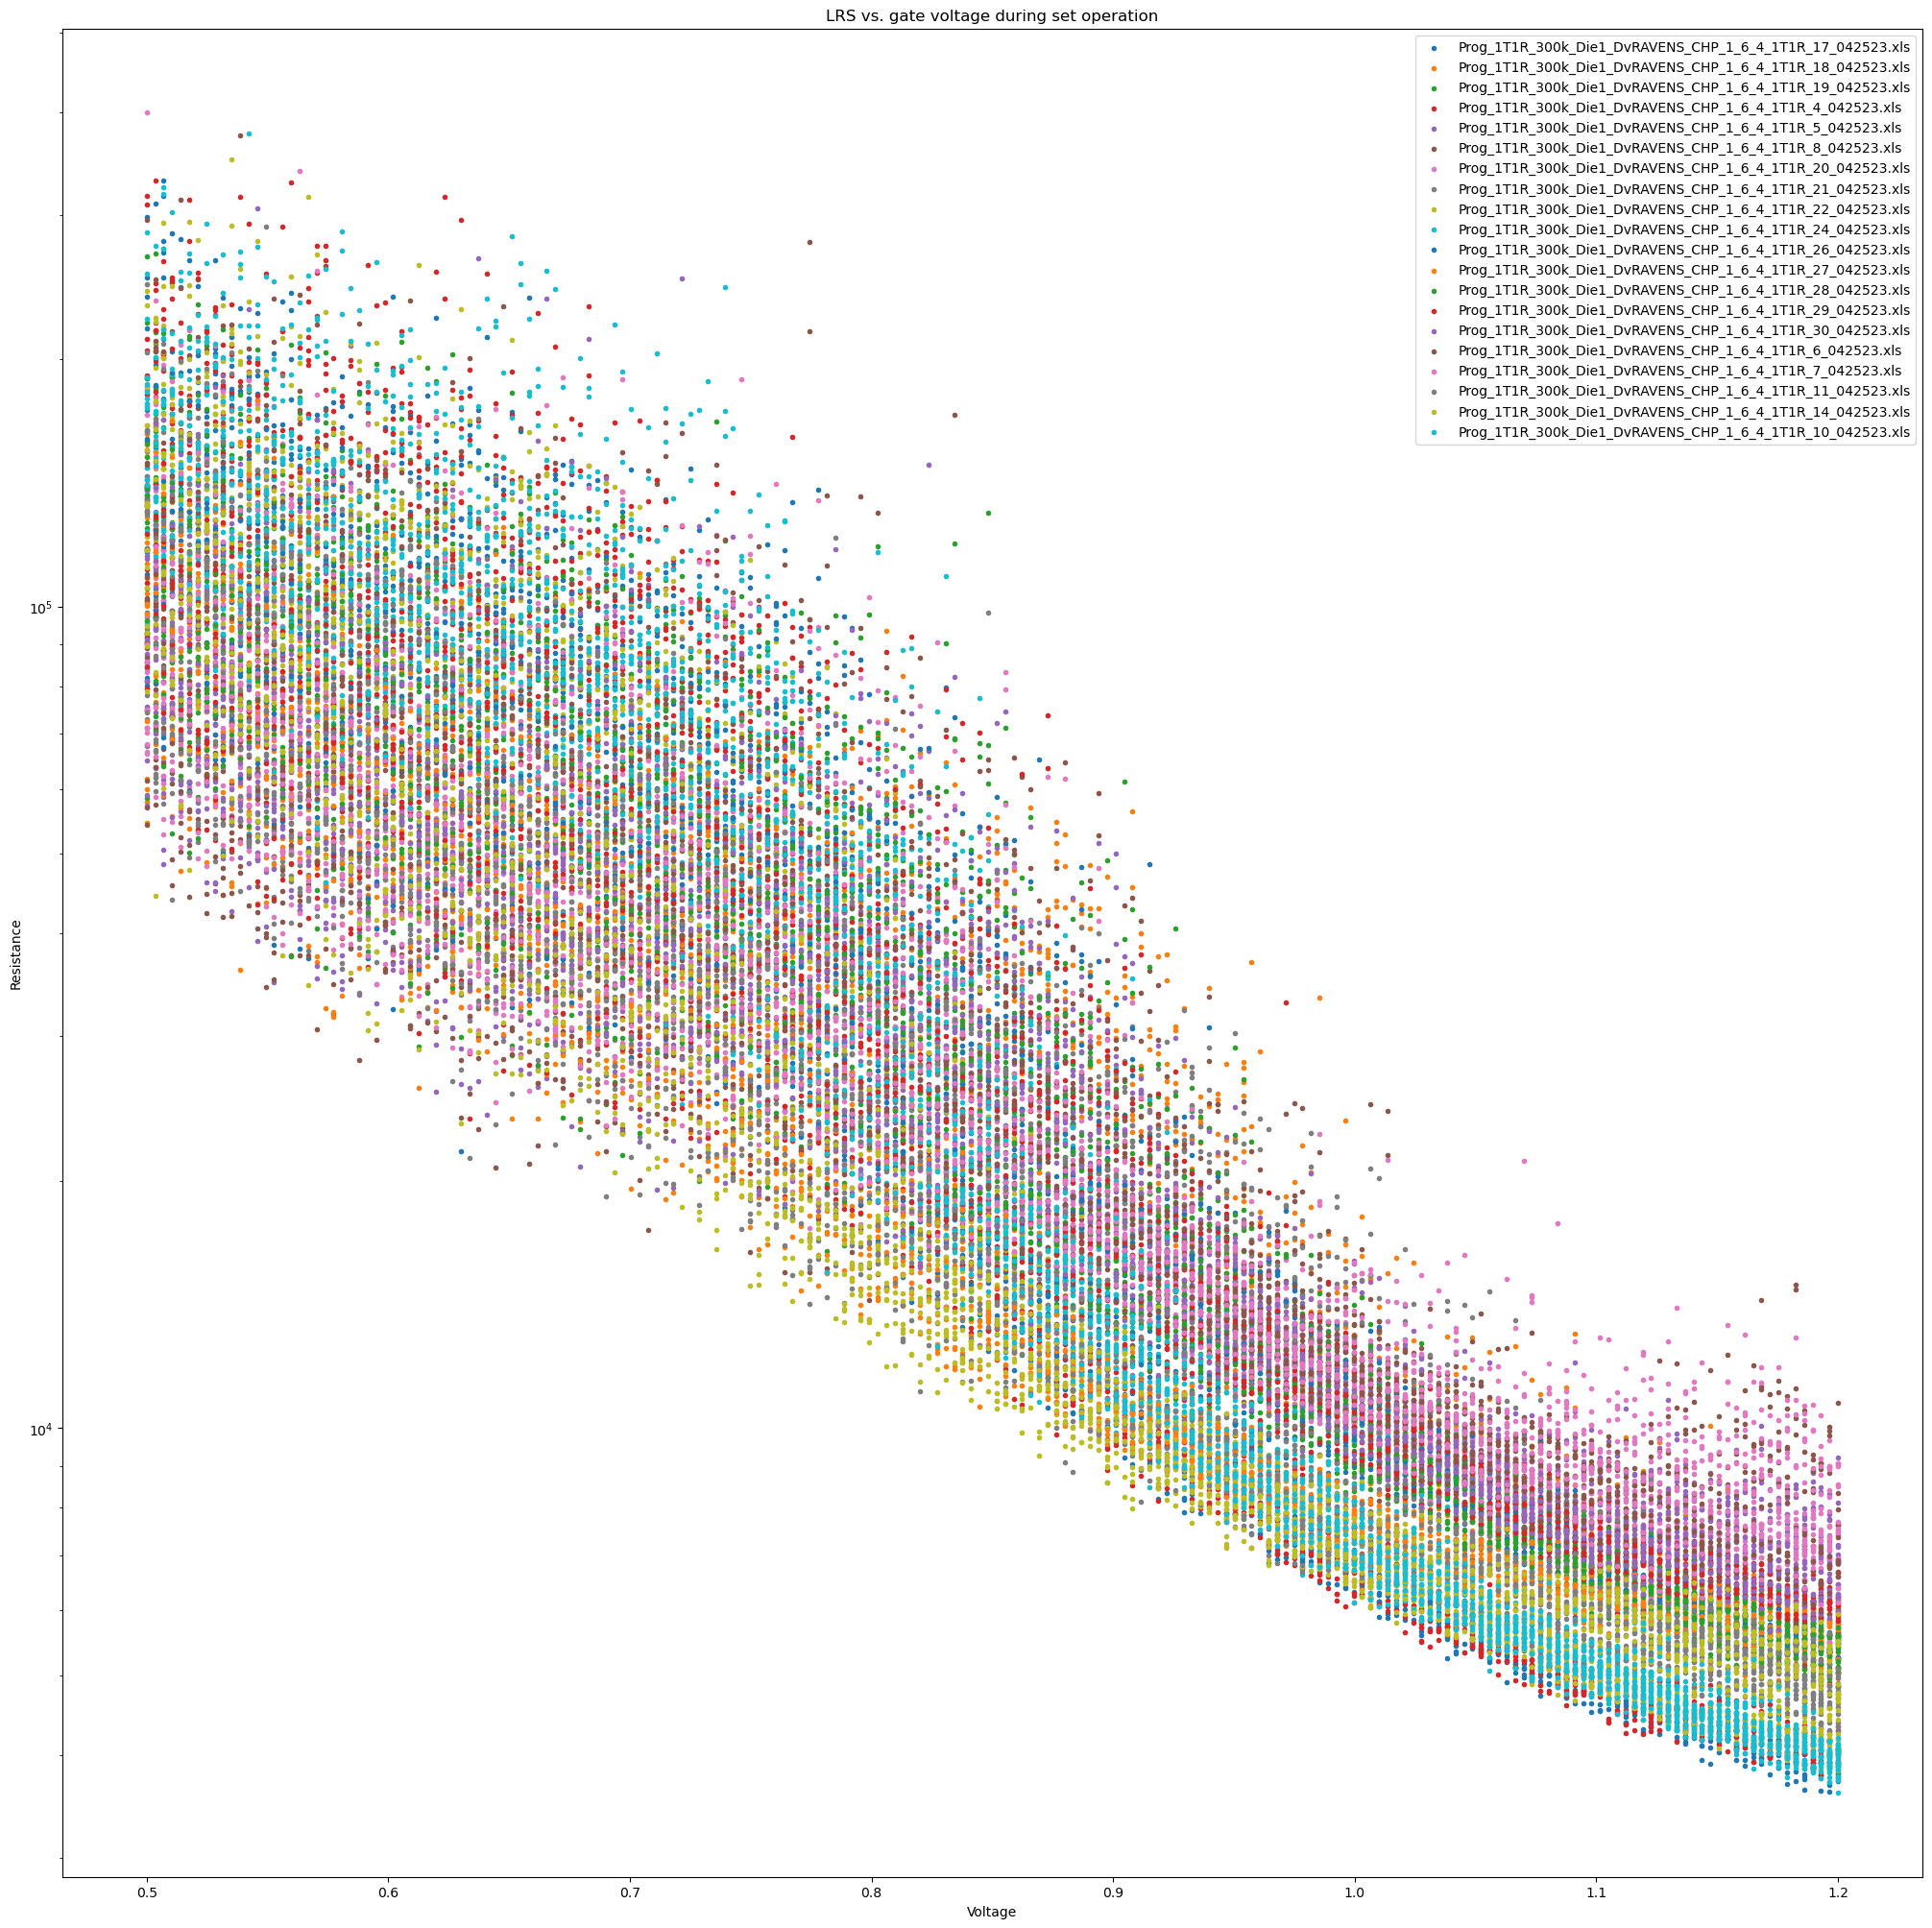

In [4]:
fig, ax = plt.subplots(figsize=(25,25))
for f, d in zip(filenames, prog_data):
    plt.title(f'LRS vs. gate voltage during set operation')
    plt.scatter(d['gatev'], d['LRS'], marker='.', label=f)
    plt.ylabel('Resistance')
    plt.xlabel('Voltage')
    plt.yscale('log')
plt.legend()
plt.show()

to better understand the way the data was collected, lets plot the LRS values in the order they were collected for a single device. (LRS vs cycle)

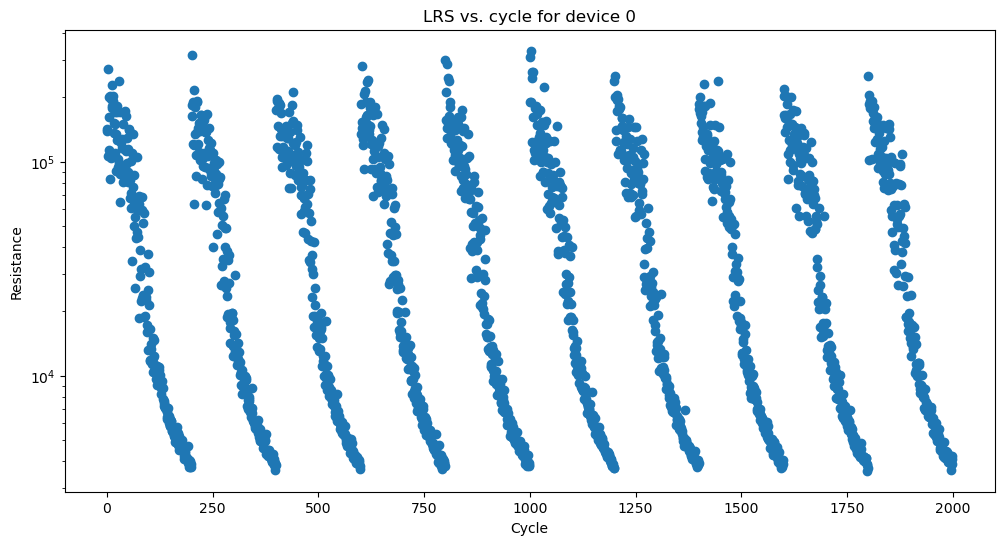

In [5]:
test_device = 0

plt.title(f'LRS vs. cycle for device {test_device}')
plt.scatter(range(len(prog_data[test_device]['LRS'])), prog_data[test_device]['LRS'])
plt.ylabel('Resistance')
plt.xlabel('Cycle')
plt.yscale('log')
plt.show()


above shows the LRS values after each set operation. Each device(1T1R) was subject to 10 groups of set/reset cycles. Each group contains 200 different LRS values which each correspond to different voltages used at the gate during set operations. This way we have 10 points to average from for each device. The gate voltage ranges from 0.5V to 1.2V

In [6]:
print(f"min: {np.min(prog_data[test_device]['gatev'])} V")
print(f"max: {np.max(prog_data[test_device]['gatev'])} V")

min: 0.5 V
max: 1.2 V


Lets look at the different resistances recorded when using the same gate voltage

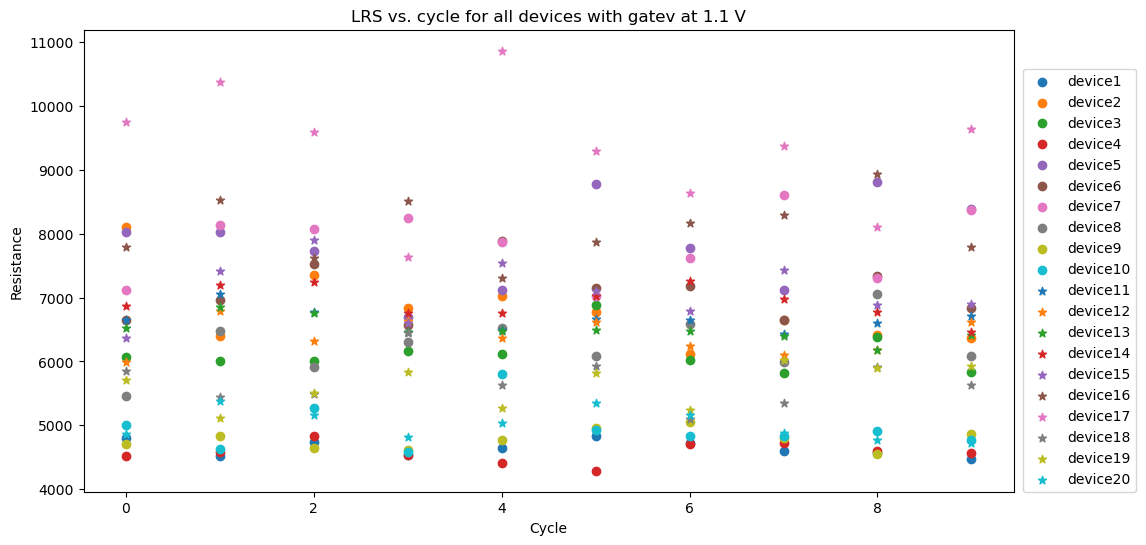

In [7]:
gate_v_idx = 175

plt.title(f"LRS vs. cycle for all devices with gatev at {prog_data[test_device]['gatev'][gate_v_idx]:.2} V")
for i, d in enumerate(prog_data):
    if i < 10:
        plt.scatter(range(10), d['LRS'][gate_v_idx:2000:200], label=f'device{i+1}')
    else:
        plt.scatter(range(10), d['LRS'][gate_v_idx:2000:200], label=f'device{i+1}', marker='*')

plt.ylabel('Resistance')
plt.xlabel('Cycle')
plt.legend(loc=(1.01,0))
plt.show()

Now we will create a box plot of LRS vs. voltage value across device 0

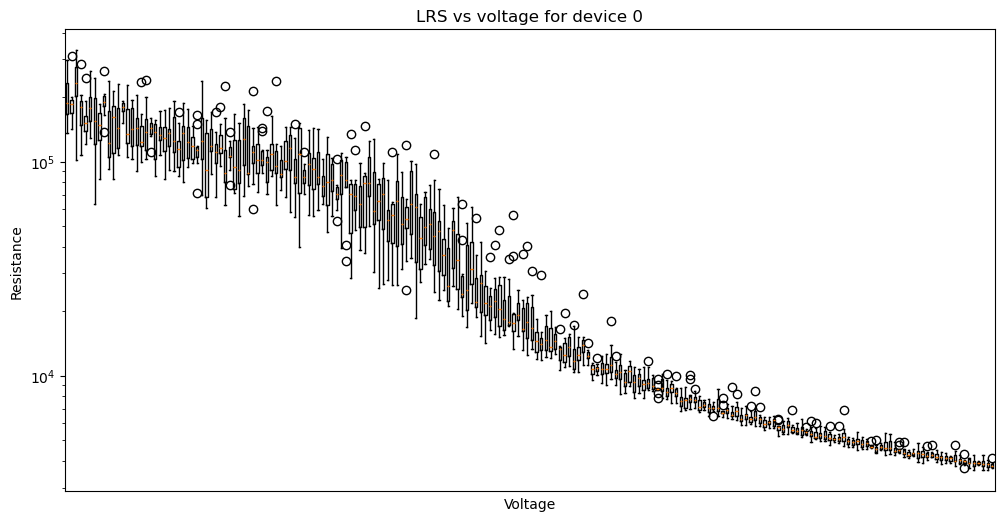

In [8]:
def get_lrs_by_voltage(device): 
    LRS_by_voltage = []

    # for each voltage value
    for v_i in range(200):
        LRS_by_voltage.append([])

        # grab the LRS from each group
        for group_j in range(10):
            LRS_by_voltage[-1].append(device['LRS'][v_i + group_j*200])
    
    return np.asarray(LRS_by_voltage).T

plt.title(f'LRS vs voltage for device {test_device}')
plt.boxplot(get_lrs_by_voltage(prog_data[test_device]))
plt.yscale('log')
plt.ylabel('Resistance')
plt.xlabel('Voltage')
plt.xticks([])
plt.show()

Instead of making a box for each of the 200 voltages, lets skip voltages. Effectively reducing the resolution of the voltage axis

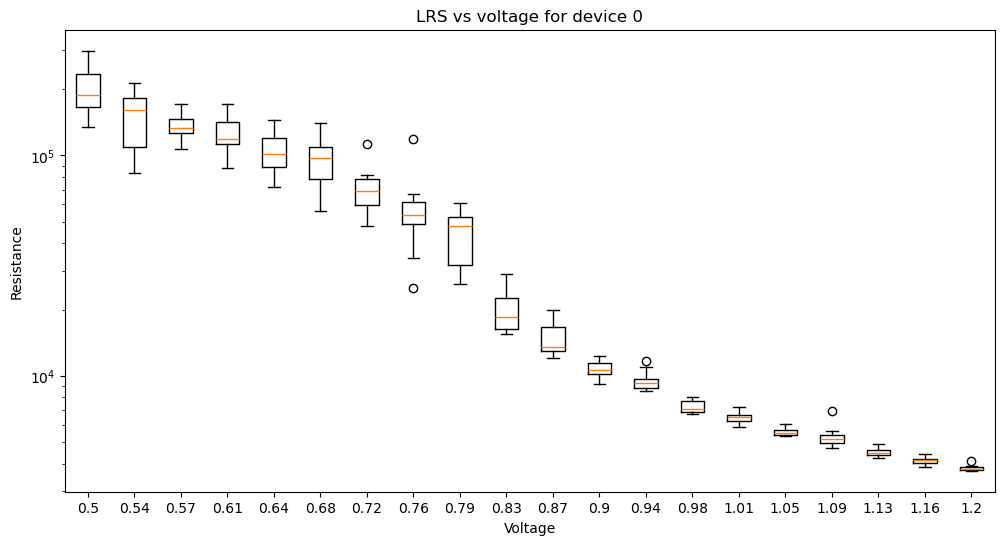

In [9]:
# slc will grab 20 elements in a list of 200
mask = np.linspace(1, 200, 20, dtype=np.int16) - 1

x_ticks = np.round(prog_data[test_device]['gatev'][mask], 2)

plt.title(f'LRS vs voltage for device {test_device}')
plt.boxplot(get_lrs_by_voltage(prog_data[test_device])[:, mask])
plt.yscale('log')
plt.ylabel('Resistance')
plt.xlabel('Voltage')
plt.xticks(range(1, 1 + len(x_ticks)), x_ticks)
plt.show()

lets take all 20 devices into consideration

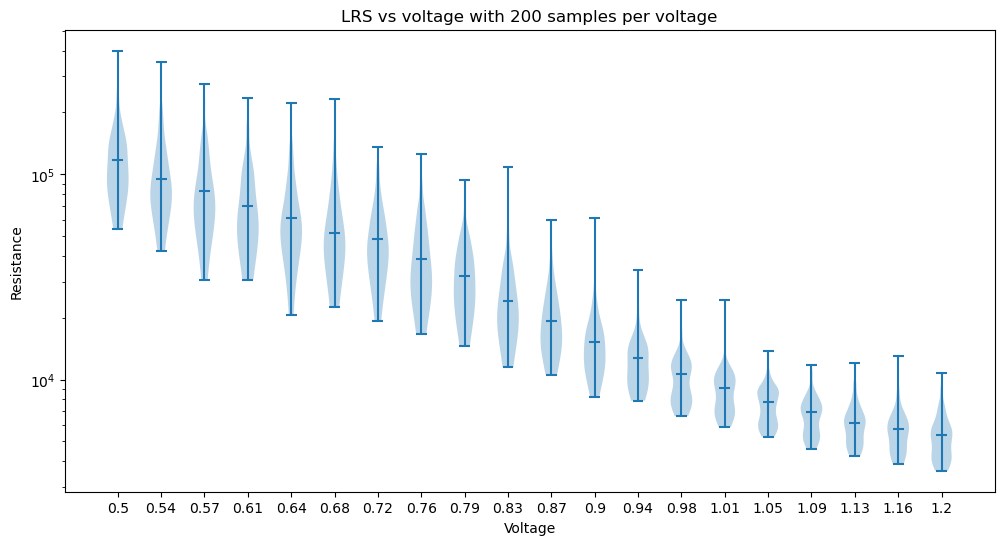

In [10]:
r_b_v = get_lrs_by_voltage(prog_data[0])[:, mask]
for d in prog_data[1:]:
    r_b_v = np.append(r_b_v, get_lrs_by_voltage(d)[:, mask], axis=0)

x_ticks = np.round(prog_data[test_device]['gatev'][mask], 2)


plt.title(f'LRS vs voltage with {len(r_b_v)} samples per voltage')
plt.violinplot(r_b_v, showmedians=True)
plt.ylabel('Resistance')
plt.xlabel('Voltage')
plt.xticks(range(1, 1 + len(x_ticks)), x_ticks)
plt.yscale('log')
plt.show()